In [0]:
%matplotlib inline

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy

## Load Dataset

In [3]:
rgb_mean = (0.4914, 0.4822, 0.4465)
rgb_std = (0.2023, 0.1994, 0.2010)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=2),  
    transforms.RandomRotation(15),                               
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 512

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Enable CUDA

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)

cuda:0


### Define Model Train & Test Functions

In [0]:
def train(model, optimizer,criterion, epoch, train_loader=trainloader, device=device):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        inputs.to("cpu")
        targets.to("cpu")
        if (batch_idx % 30 == 0):
            print('Loss: %.3f | Acc: %.3f%% (%d/%d)'
               % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

def test(model, device, test_loader=testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100. * correct / total
    print('Accuracy of the network on the test images: %.3f %%' % (accuracy))
    return accuracy

### Define Architecture

In [0]:
class ConvBrick(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, p=0, *args, **kwargs):
        super(ConvBrick, self).__init__()

        self.nothing = lambda x: x

        self.norm = nn.BatchNorm2d(out_channels)
        self.drop = nn.Dropout2d(p) if p>0 else self.nothing
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, *args, **kwargs)
        self.actf = F.relu

    def forward(self, x):
        x = self.drop(x)
        x = self.conv(x)
        x = self.norm(x)
        x = self.actf(x)
        return x

In [0]:
class LinearBrick(nn.Module):
    def __init__(self, in_features, out_features, activation=F.relu, p=0):
        super(LinearBrick, self).__init__()

        self.nothing = lambda x: x

        self.norm = nn.BatchNorm1d(in_features)
        self.drop = nn.Dropout(p) if p>0 else self.nothing
        self.fc   = nn.Linear(in_features, out_features)
        self.actf = activation if activation is not None else self.nothing

    def forward(self, x):
        x = self.norm(x)
        x = self.drop(x)
        x = self.fc(x)
        x = self.actf(x)
        return x

In [0]:
class SadNet(nn.Module):
    def __init__(self, enable_dropout=True):
        super(SadNet, self).__init__()

        self.maxch = 4096*2

        self.conv11 = ConvBrick(3, 128, 3, padding=1)
        self.conv12 = ConvBrick(128, 128, 3, padding=1)
        self.pool1  = nn.MaxPool2d(2, 2)

        self.conv21 = ConvBrick(128, 256, 3, padding=1)
        self.conv22 = ConvBrick(256, 256, 3, padding=1)
        self.pool2  = nn.MaxPool2d(2, 2)
        
        self.conv31 = ConvBrick(256, 512, 3, padding=1)
        self.conv32 = ConvBrick(512, 512, 3, padding=1)
        self.pool3  = nn.MaxPool2d(2, 2)

        self.conv41 = ConvBrick(512, 1024, 3, padding=1)
        self.conv42 = ConvBrick(1024, 2048, 3, padding=1)
        self.pool4  = nn.MaxPool2d(2, 2)

        self.conv51 = ConvBrick(2048, 4096, 3, padding=1)
        self.conv52 = ConvBrick(4096, self.maxch, 3, padding=1)
        self.pool5  = nn.MaxPool2d(2, 2)

        self.pool6 = nn.AvgPool2d(kernel_size=1, stride=1)

        self.fc1 = LinearBrick(self.maxch, 512, p=0.4)
        self.fc2 = LinearBrick(512, 10, activation=None, p=0.4)
        
    def forward(self, x):
        x = self.conv12(self.conv11(x))
        x = self.pool1(x)
        x = self.conv22(self.conv21(x))
        x = self.pool2(x)
        x = self.conv32(self.conv31(x))
        x = self.pool3(x)
        x = self.conv42(self.conv41(x))
        x = self.pool4(x)
        x = self.conv52(self.conv51(x))
        x = self.pool5(x)

        x = self.pool6(x)
        x = x.view(-1, self.maxch)
        x = self.fc1(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [0]:
model = SadNet().to(device)

### Train & Test the model

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(), 
    lr=0.01, momentum=0.9
    )

In [11]:
epochs = 30
max_accuracy = 0
for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}")
    train(model, optimizer, criterion, epoch, device=device)
    acc = test(model, device)
    if acc > max_accuracy:
        max_accuracy = acc
        best_wts = copy.deepcopy(model.state_dict())

Epoch 1
Loss: 2.507 | Acc: 11.133% (57/512)
Loss: 1.751 | Acc: 36.649% (5817/15872)
Loss: 1.577 | Acc: 43.023% (13437/31232)
Loss: 1.471 | Acc: 46.615% (21719/46592)
Accuracy of the network on the test images: 59.880 %
Epoch 2
Loss: 1.104 | Acc: 58.789% (301/512)
Loss: 1.116 | Acc: 59.734% (9481/15872)
Loss: 1.070 | Acc: 61.757% (19288/31232)
Loss: 1.038 | Acc: 62.876% (29295/46592)
Accuracy of the network on the test images: 67.100 %
Epoch 3
Loss: 0.991 | Acc: 65.820% (337/512)
Loss: 0.876 | Acc: 69.223% (10987/15872)
Loss: 0.859 | Acc: 69.781% (21794/31232)
Loss: 0.833 | Acc: 70.671% (32927/46592)
Accuracy of the network on the test images: 72.630 %
Epoch 4
Loss: 0.763 | Acc: 73.633% (377/512)
Loss: 0.734 | Acc: 74.023% (11749/15872)
Loss: 0.725 | Acc: 74.315% (23210/31232)
Loss: 0.724 | Acc: 74.470% (34697/46592)
Accuracy of the network on the test images: 76.520 %
Epoch 5
Loss: 0.646 | Acc: 77.344% (396/512)
Loss: 0.655 | Acc: 77.092% (12236/15872)
Loss: 0.646 | Acc: 77.523% (24212

In [12]:
model.load_state_dict(best_wts)
print(f"Max accuracy: {max_accuracy}%")

Max accuracy: 87.37%


In [0]:
torch.save(best_wts, "checkpoint1.pth")

In [10]:
model.load_state_dict(torch.load("checkpoint1.pth"))

<All keys matched successfully>

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(
    model.parameters(), 
    lr=1e-2,
    weight_decay=5e-4
    )
# quick fix
max_accuracy=89.43
best_wts = copy.deepcopy(model.state_dict())
# end of quick fix
epochs = 60
for epoch in range(32, epochs + 1):
    print(f"Epoch {epoch}")
    train(model, optimizer, criterion, epoch, device=device)
    acc = test(model, device)
    if acc > max_accuracy:
        max_accuracy = acc
        best_wts = copy.deepcopy(model.state_dict())

Epoch 32
Loss: 0.121 | Acc: 95.508% (489/512)
Loss: 0.110 | Acc: 96.390% (15299/15872)
Loss: 0.107 | Acc: 96.478% (30132/31232)
Loss: 0.108 | Acc: 96.465% (44945/46592)
Accuracy of the network on the test images: 89.550 %
Epoch 33
Loss: 0.107 | Acc: 96.484% (494/512)
Loss: 0.100 | Acc: 96.856% (15373/15872)
Loss: 0.097 | Acc: 96.904% (30265/31232)
Loss: 0.097 | Acc: 96.884% (45140/46592)
Accuracy of the network on the test images: 89.560 %
Epoch 34
Loss: 0.073 | Acc: 97.852% (501/512)
Loss: 0.086 | Acc: 97.348% (15451/15872)
Loss: 0.089 | Acc: 97.166% (30347/31232)
Loss: 0.090 | Acc: 97.075% (45229/46592)
Accuracy of the network on the test images: 89.760 %
Epoch 35
Loss: 0.111 | Acc: 95.117% (487/512)
Loss: 0.092 | Acc: 97.064% (15406/15872)
Loss: 0.088 | Acc: 97.128% (30335/31232)
Loss: 0.089 | Acc: 97.148% (45263/46592)
Accuracy of the network on the test images: 89.740 %
Epoch 36
Loss: 0.082 | Acc: 96.875% (496/512)
Loss: 0.085 | Acc: 97.272% (15439/15872)
Loss: 0.083 | Acc: 97.384

KeyboardInterrupt: ignored

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


In [13]:
model.load_state_dict(best_wts)
print(f"Max accuracy: {max_accuracy}%")

Max accuracy: 90.08%


In [0]:
torch.save(best_wts, "checkpoint1.pth")

### Save model weights

In [0]:
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()

In [0]:
drive_service = build('drive', 'v3')

def save_file_to_drive(name, path):
    file_metadata = {
      'name': name,
      'mimeType': 'application/octet-stream'
     }

    media = MediaFileUpload(path, 
                    mimetype='application/octet-stream',
                    resumable=True)

    created = drive_service.files().create(body=file_metadata,
                                   media_body=media,
                                   fields='id').execute()

    print('File ID: {}'.format(created.get('id')))

    return created

In [18]:
save_file_to_drive("weights90.pth", "checkpoint1.pth")

File ID: 1REZfpoGq6kapG3MMxhh4cpy6gbP8zZsb


{'id': '1REZfpoGq6kapG3MMxhh4cpy6gbP8zZsb'}

## Evaluate My Model



### Define useful functions

In [0]:
import sklearn.metrics as metrics
import numpy as np
from matplotlib import pyplot as plt

In [0]:
# lets form a confusion matrix!
# ..and predicted labels array

y_true = np.array(testset.targets, dtype=int)

def get_predictions_confusion(model):

  model.to(device)

  confusion_matrix = np.zeros((10,10))
  y_pred = np.zeros(y_true.shape, dtype=int)
  j = 0
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs, 1)

          for i in range(labels.shape[0]):
              true_label = labels[i]
              pred_label = predicted[i]

              confusion_matrix[true_label, pred_label] += 1

              y_pred[j] = pred_label
              j += 1
  return y_pred, confusion_matrix


In [0]:
# plot confusion matrix
def plot_confusion(model, confusion_matrix):
  # normalize confusion matrix
  normalized_confusion = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)

  # plot confusion matrix
  disp = metrics.ConfusionMatrixDisplay(normalized_confusion,
                                    display_labels=classes)

  fig, ax = plt.subplots(figsize=(10,10))
  return disp.plot(ax=ax)

In [0]:
# compute precision, recall, f1 score
def precision_recall_f1(model, y_true, y_pred):

  precision, recall, f1score, _ = metrics.precision_recall_fscore_support(
      y_true, y_pred,
      # average='samples',
      labels=list(range(10))
    )
  print("Class  |   Precision  Recall  F1-score \n")

  for i in range(10):
    print("{cls}     {prc}  {rcl}  {f1}".format(
        cls = classes[i],
        prc = precision[i],
        rcl = recall[i],
        f1 = f1score[i]
    ))

### Use functions to get metrics

In [23]:
print(f"Best accuracy: {max_accuracy}")

Best accuracy: 90.08


In [0]:
y_pred, confusion = get_predictions_confusion(model)

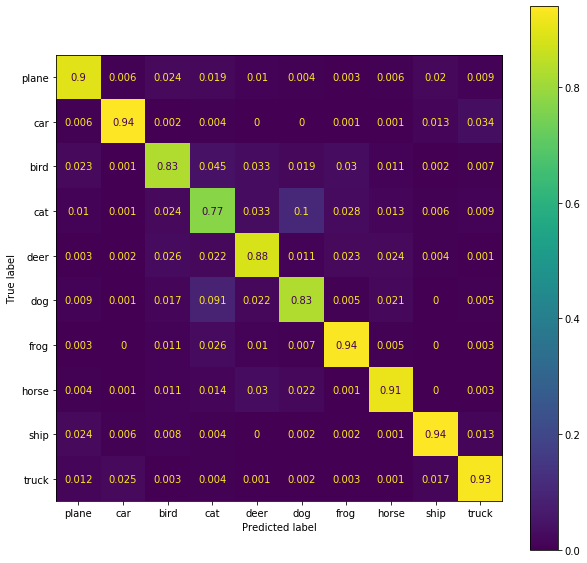

In [25]:
plot_confusion(model, confusion)

In [26]:
precision_recall_f1(model, y_true, y_pred)

Class  |   Precision  Recall  F1-score 

plane     0.905337361530715  0.899  0.902157551430005
car     0.9562118126272913  0.939  0.9475277497477296
bird     0.8680628272251308  0.829  0.8480818414322249
cat     0.7712287712287712  0.772  0.7716141929035484
deer     0.8641251221896383  0.884  0.8739495798319327
dog     0.829  0.829  0.8289999999999998
frog     0.906886517943744  0.935  0.9207287050713935
horse     0.9167502507522568  0.914  0.9153730595893842
ship     0.93812375249501  0.94  0.9390609390609391
truck     0.9173228346456693  0.932  0.9246031746031745
